In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


Missing Values After Imputation:
id                             0
Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
dtype: int64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


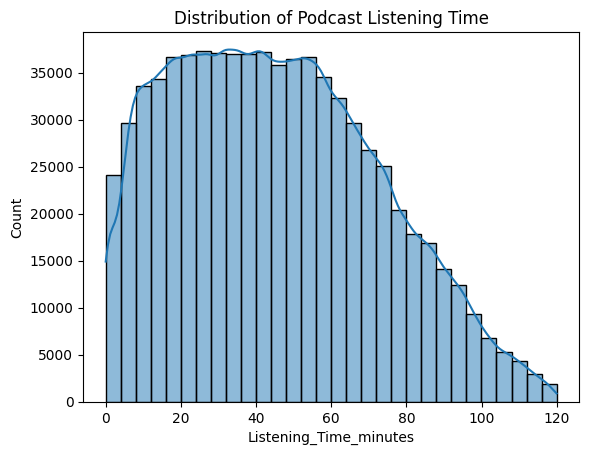

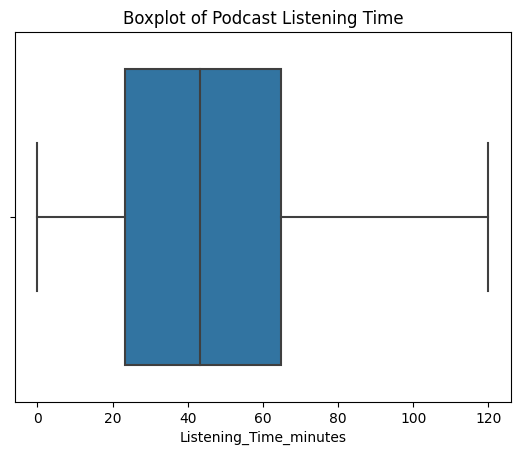

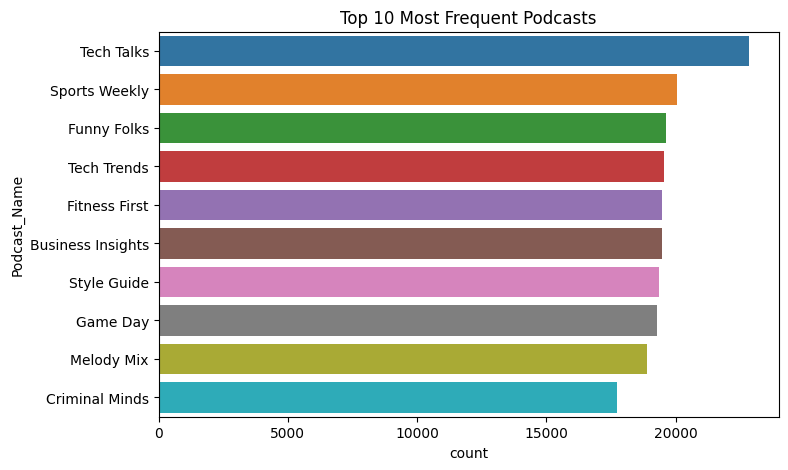

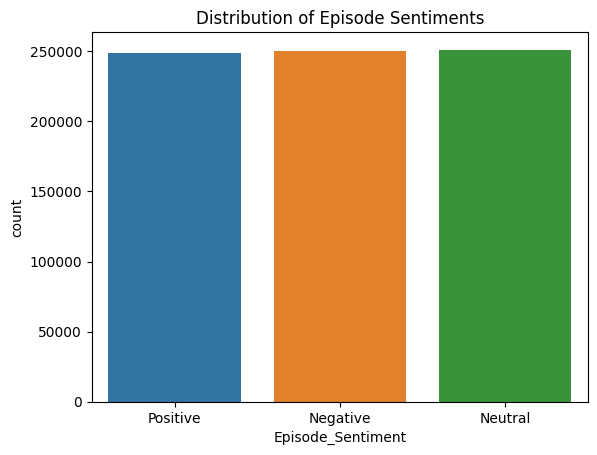

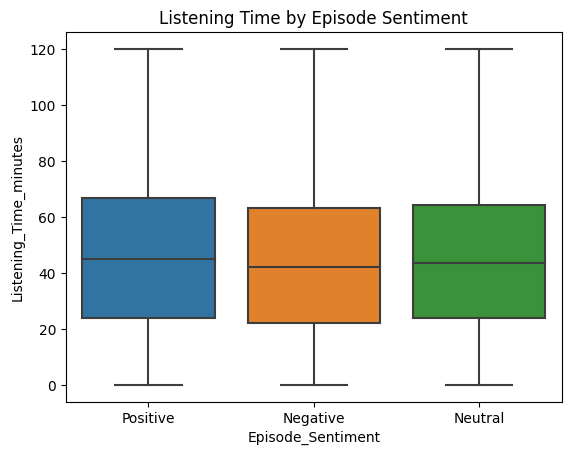

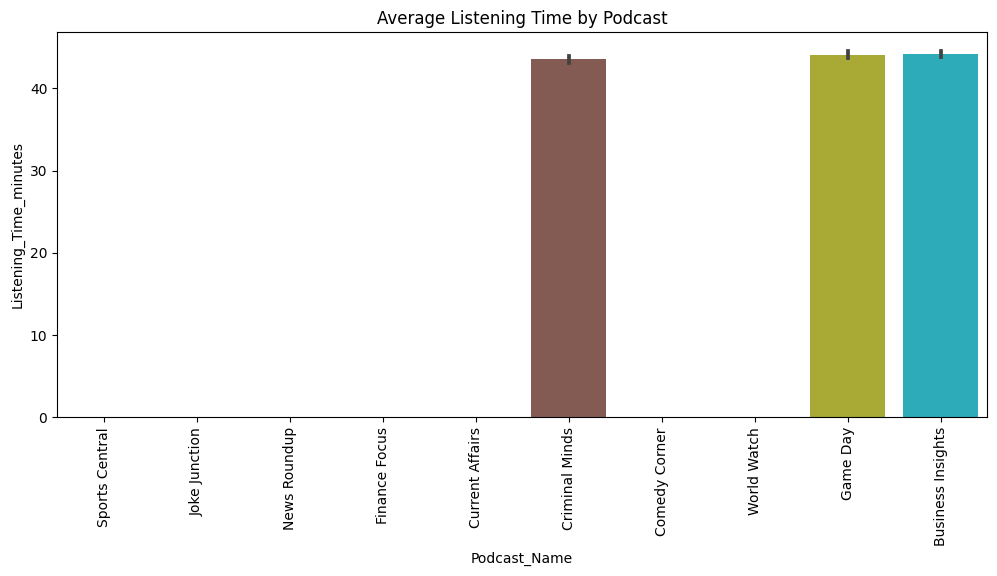

Correlation Matrix:
                             Episode_Length_minutes  \
Episode_Length_minutes                     1.000000   
Host_Popularity_percentage                 0.022191   
Guest_Popularity_percentage               -0.008336   
Number_of_Ads                             -0.051834   
Listening_Time_minutes                     0.866221   

                             Host_Popularity_percentage  \
Episode_Length_minutes                         0.022191   
Host_Popularity_percentage                     1.000000   
Guest_Popularity_percentage                    0.020416   
Number_of_Ads                                 -0.017895   
Listening_Time_minutes                         0.050870   

                             Guest_Popularity_percentage  Number_of_Ads  \
Episode_Length_minutes                         -0.008336      -0.051834   
Host_Popularity_percentage                      0.020416      -0.017895   
Guest_Popularity_percentage                     1.000000       0.0081

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


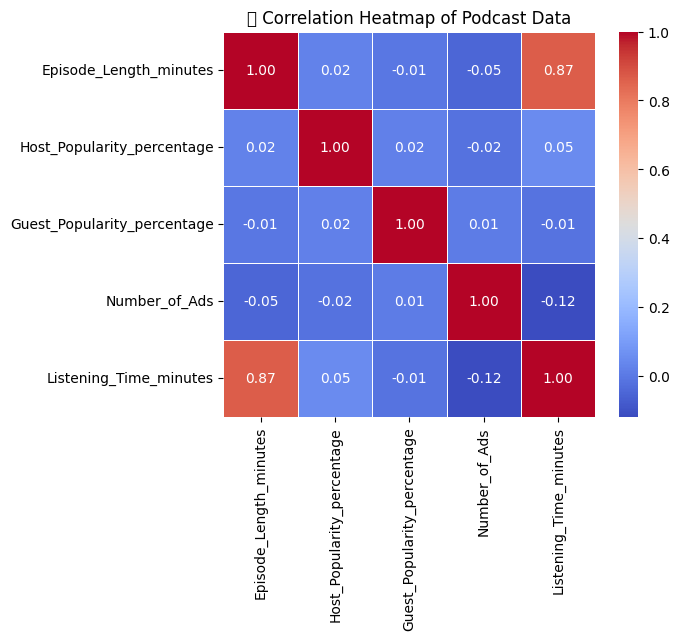

In [12]:
import dask.dataframe as dd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# 1. Load data with proper dtypes
df = dd.read_csv("/kaggle/input/playground-series-s5e4/train.csv", dtype={
    'Podcast_Name': 'category',
    'Episode_Title': 'category',
    'Genre': 'category',
    'Publication_Day': 'category',
    'Publication_Time': 'category',
    'Episode_Sentiment': 'category'
})

# 2. Convert Dask DataFrame to pandas for processing
df = df.compute()

# 3. Separate numerical and categorical columns
numerical_features = ['Episode_Length_minutes', 'Guest_Popularity_percentage', 'Number_of_Ads']
categorical_features = ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']

# 4. Impute numerical features with median
num_imputer = SimpleImputer(strategy="median")
df[numerical_features] = num_imputer.fit_transform(df[numerical_features])

# 5. Impute categorical features with mode
cat_imputer = SimpleImputer(strategy="most_frequent")
df[categorical_features] = cat_imputer.fit_transform(df[categorical_features])

# 6. Check for missing values
print("\nMissing Values After Imputation:")
print(df.isnull().sum())

# 7. EDA plots
sns.histplot(df['Listening_Time_minutes'], bins=30, kde=True)
plt.title("Distribution of Podcast Listening Time")
plt.show()

sns.boxplot(x=df['Listening_Time_minutes'])
plt.title("Boxplot of Podcast Listening Time")
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(y=df['Podcast_Name'], order=df['Podcast_Name'].value_counts().index[:10])
plt.title("Top 10 Most Frequent Podcasts")
plt.show()

sns.countplot(x=df['Episode_Sentiment'])
plt.title("Distribution of Episode Sentiments")
plt.show()

sns.boxplot(x='Episode_Sentiment', y='Listening_Time_minutes', data=df)
plt.title("Listening Time by Episode Sentiment")
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x='Podcast_Name', y='Listening_Time_minutes', 
            data=df[df['Podcast_Name'].isin(df['Podcast_Name'].value_counts().index[:10])],
            order=df.groupby('Podcast_Name')['Listening_Time_minutes'].mean().sort_values().index[:10])
plt.xticks(rotation=90)
plt.title("Average Listening Time by Podcast")
plt.show()

# 8. Correlation heatmap
numeric_cols = ['Episode_Length_minutes', 'Host_Popularity_percentage',
                'Guest_Popularity_percentage', 'Number_of_Ads', 'Listening_Time_minutes']

df_numeric = df[numeric_cols]
corr_matrix = df_numeric.corr()

print("Correlation Matrix:")
print(corr_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("🔹 Correlation Heatmap of Podcast Data")
plt.show()

  

In [14]:
import pandas as pd

# Sample DataFrame (Replace this with your actual dataset)
# df = pd.read_csv("your_data.csv")
# 1. Podcast-Level Aggregations
podcast_features = df.groupby("Podcast_Name").agg(
    avg_podcast_listening_time=('Listening_Time_minutes', 'mean'),
    median_podcast_listening_time=('Listening_Time_minutes', 'median'),
    total_podcast_listens=('Listening_Time_minutes', 'count'),
    std_podcast_listening_time=('Listening_Time_minutes', 'std'),
    avg_episode_length=('Episode_Length_minutes', 'mean'),
    avg_host_popularity=('Host_Popularity_percentage', 'mean'),
    avg_guest_popularity=('Guest_Popularity_percentage', 'mean'),
    avg_num_ads=('Number_of_Ads', 'mean')
).reset_index()

# 2. Genre-Level Aggregations
genre_features = df.groupby("Genre").agg(
    avg_genre_listening_time=('Listening_Time_minutes', 'mean'),
    avg_genre_episode_length=('Episode_Length_minutes', 'mean'),
    total_genre_listens=('Listening_Time_minutes', 'count')
).reset_index()

# 3. Sentiment-Based Aggregations
sentiment_features = df.groupby("Episode_Sentiment").agg(
    avg_sentiment_listening_time=('Listening_Time_minutes', 'mean'),
    total_sentiment_listens=('Listening_Time_minutes', 'count')
).reset_index()

# 4. Publication Day Patterns
day_features = df.groupby("Publication_Day").agg(
    avg_day_listening_time=('Listening_Time_minutes', 'mean'),
    total_day_listens=('Listening_Time_minutes', 'count')
).reset_index()

# 5. Merge the new features into the main dataset
df = df.merge(podcast_features, on="Podcast_Name", how="left")
df = df.merge(genre_features, on="Genre", how="left")
df = df.merge(sentiment_features, on="Episode_Sentiment", how="left")
df = df.merge(day_features, on="Publication_Day", how="left")

# Handle NaN values (if any)
df.fillna(0, inplace=True)

# Save the enhanced dataset
# df.to_csv("enhanced_dataset.csv", index=False)
print(df.head())  # Display the first few rows




   id     Podcast_Name Episode_Title  Episode_Length_minutes       Genre  \
0   0  Mystery Matters    Episode 98                   63.84  True Crime   
1   1    Joke Junction    Episode 26                  119.80      Comedy   
2   2   Study Sessions    Episode 16                   73.90   Education   
3   3   Digital Digest    Episode 45                   67.17  Technology   
4   4      Mind & Body    Episode 86                  110.51      Health   

   Host_Popularity_percentage Publication_Day Publication_Time  \
0                       74.81        Thursday            Night   
1                       66.95        Saturday        Afternoon   
2                       69.97         Tuesday          Evening   
3                       57.22          Monday          Morning   
4                       80.07          Monday        Afternoon   

   Guest_Popularity_percentage  Number_of_Ads  ... avg_host_popularity_y  \
0                        53.58            0.0  ...             59.5904

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Make a copy of the data
df_model = df.copy()

# Drop unneeded columns or identifiers
df_model.drop(['id', 'Episode_Title'], axis=1, inplace=True)

# Label encode categorical variables
cat_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

# Define X (features) and y (target)
X = df_model.drop('Listening_Time_minutes', axis=1)
y = df_model['Listening_Time_minutes']


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance
importances = rf.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)


In [ ]:
# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 Most Important Features for Listening Time Prediction')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Label encode categorical columns
df_model = df.copy()
cat_cols = ['Podcast_Name', 'Genre', 'Publication_Day', 'Publication_Time', 'Episode_Sentiment']
for col in cat_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])

# Drop ID and Episode_Title
df_model.drop(['id', 'Episode_Title'], axis=1, inplace=True)

# Features and target
X = df_model.drop('Listening_Time_minutes', axis=1)
y = df_model['Listening_Time_minutes']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Models dictionary
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# Store RMSE results
results = {}

# Train & evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    results[name] = rmse
    print(f"{name} RMSE: {rmse:.2f}")


In [ ]:
# Display RMSEs
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE']).sort_values(by='RMSE')
print("\nModel Performance (Lower RMSE is Better):\n")
print(results_df)


In [ ]:
# Display RMSEs
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE']).sort_values(by='RMSE')
print("\nModel Performance (Lower RMSE is Better):\n")
print(results_df)
